## **Importing the required libraries**

In [32]:
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [1]:
!git clone "https://github.com/RA2111027010125/CVIP_DataScienceIntern.git"

Cloning into 'CVIP_DataScienceIntern'...
remote: Enumerating objects: 1056, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 1056 (delta 11), reused 125 (delta 7), pack-reused 925
Receiving objects: 100% (1056/1056), 72.20 MiB | 30.05 MiB/s, done.
Resolving deltas: 100% (35/35), done.


In [11]:
!git clone https://github.com/RA2111027010125/CVIP_DataScienceIntern/tree/main/Datasets/OAF_Fear

Cloning into 'OAF_Fear'...
fatal: repository 'https://github.com/RA2111027010125/CVIP_DataScienceIntern/tree/main/Datasets/OAF_Fear/' not found


In [4]:
from keras import regularizers
import os

In [14]:
mylist= os.listdir('/content/CVIP_DataScienceIntern/Datasets/OAF_angry')

In [15]:
type(mylist)
mylist

['OAF_make_angry.wav',
 'OAF_reach_angry.wav',
 'OAF_phone_angry.wav',
 'OAF_mouse_angry.wav',
 'OAF_juice_angry.wav',
 'OAF_name_angry.wav',
 'OAF_moon_angry.wav',
 'OAF_hush_angry.wav',
 'OAF_haze_angry.wav',
 'OAF_raise_angry.wav',
 'OAF_hole_angry.wav',
 'OAF_nice_angry.wav',
 'OAF_page_angry.wav',
 'OAF_keep_angry.wav',
 'OAF_pick_angry.wav',
 'OAF_rot_angry.wav',
 'OAF_peg_angry.wav',
 'OAF_lid_angry.wav',
 'OAF_seize_angry.wav',
 'OAF_said_angry.wav',
 'OAF_hit_angry.wav',
 'OAF_lean_angry.wav',
 'OAF_kill_angry.wav',
 'OAF_mood_angry.wav',
 'OAF_sell_angry.wav',
 'OAF_puff_angry.wav',
 'OAF_raid_angry.wav',
 'OAF_numb_angry.wav',
 'OAF_pool_angry.wav',
 'OAF_pass_angry.wav',
 'OAF_rush_angry.wav',
 'OAF_met_angry.wav',
 'OAF_join_angry.wav',
 'OAF_ring_angry.wav',
 'OAF_loaf_angry.wav',
 'OAF_rain_angry.wav',
 'OAF_limb_angry.wav',
 'OAF_keg_angry.wav',
 'OAF_lease_angry.wav',
 'OAF_pad_angry.wav',
 'OAF_late_angry.wav',
 'OAF_note_angry.wav',
 'OAF_knock_angry.wav',
 'OAF_near

In [16]:
print(mylist[80])

OAF_life_angry.wav


## **Plotting the audio file's waveform and its spectrogram**

In [17]:
data, sampling_rate = librosa.load('/content/CVIP_DataScienceIntern/Datasets/OAF_angry/OAF_haze_angry.wav')

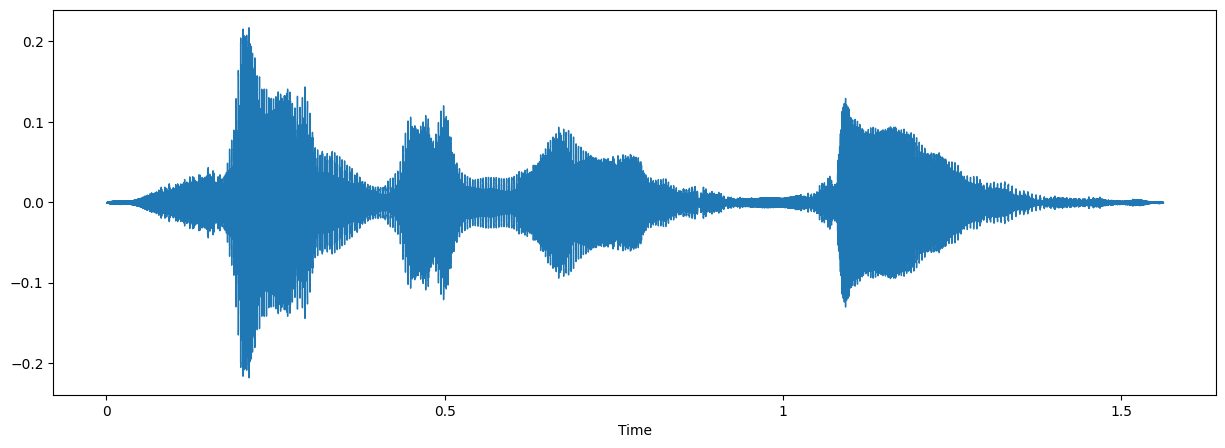

In [18]:
import os
import pandas as pd
import librosa
import glob

plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

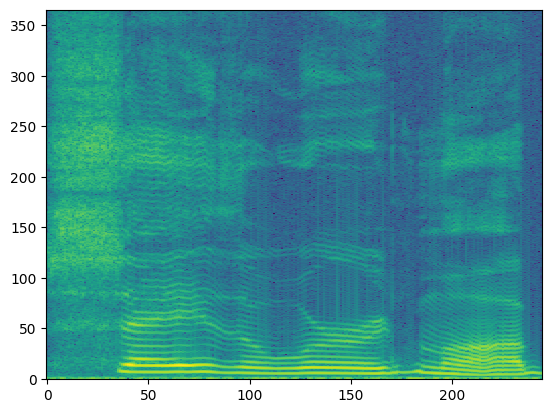

In [19]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('/content/CVIP_DataScienceIntern/Datasets/OAF_Sad/OAF_mob_sad.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()


## **Setting the labels**

In [20]:
def extract_feature(file_name, mfcc, chroma, mel):
    with mylist.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        if chroma:
            stft = np.abs(librosa.stft(X))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, mel))
    return result


In [21]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
#DataFlair - Emotions to observe
observed_emotions=['calm', 'happy', 'fearful', 'disgust']

In [22]:
#DataFlair - Load the data and extract features for each sound file
def load_data(test_size=0.2):
    x,y=[],[]
    for file in glob.glob("/content/CVIP_DataScienceIntern/Datasets/OAF_Sad"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("_")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [59]:
data = {
    'file_path': ['/content/CVIP_DataScienceIntern/Datasets/OAF_happy/','/content/CVIP_DataScienceIntern/Datasets/OAF_happy/OAF_mob_happy.wav',
                 '/content/CVIP_DataScienceIntern/Datasets/OAF_happy/OAF_mood_happy.wav','/content/CVIP_DataScienceIntern/Datasets/OAF_happy/OAF_nag_happy.wav',
                  '/content/CVIP_DataScienceIntern/Datasets/OAF_happy/OAF_nag_happy.wav','/content/CVIP_DataScienceIntern/Datasets/OAF_happy/OAF_pad_happy.wav',
                  '/content/CVIP_DataScienceIntern/Datasets/YAF_angry/YAF_moon_angry.wav','/content/CVIP_DataScienceIntern/Datasets/OAF_neutral/OAF_mode_neutral.wav',
                  '/content/CVIP_DataScienceIntern/Datasets/OAF_Pleasant_surprise/OAF_mode_ps.wav','/content/CVIP_DataScienceIntern/Datasets/OAF_Sad/OAF_mood_sad.wav'],
    'emotion': ['happy','happy','happy','happy','happy','happy','angry','neutral','calm','sad'],  # Ensure that this list has the same length as 'file_path'
}

# Check if the lists have the same length
if len(data['file_path']) != len(data['emotion']):
    raise ValueError("All arrays must be of the same length")

df = pd.DataFrame(data)


x=data['file_path']
y=data['emotion']
x=np.array(x)
x=x.reshape(-1,1)
y=np.array(y)
y=y.reshape(-1,1)

label_encoder = LabelEncoder()
df['emotion_encoded'] = label_encoder.fit_transform(df['emotion'])
df['filepath_encoded'] = label_encoder.fit_transform(df['file_path'])




In [60]:
#DataFlair - Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df['filepath_encoded'].tolist(), df['emotion_encoded'], test_size=0.2, random_state=42)
X_train = np.array(X_train).reshape(-1, 1)
y_train = np.array(y_train).reshape(-1, 1)
X_test = np.array(X_train).reshape(-1, 1)
y_test = np.array(y_train).reshape(-1, 1)

In [61]:
#Now, let’s initialize an MLPClassifier. This is a Multi-layer Perceptron Classifier;
#it optimizes the log-loss function using LBFGS or stochastic gradient descent.
#Unlike SVM or Naive Bayes, the MLPClassifier has an internal neural network for the purpose of classification.
#This is a feedforward ANN model.

model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)
model

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [62]:
model.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [63]:
y_pred=model.predict(X_test)

In [65]:
#DataFlair - Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
#DataFlair - Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy))

Accuracy: 1.00%
